In [0]:
#if arguments are passed in 
trainFile = str(sys.argv[1])
trainLabelFile = str(sys.argv[2])
testFile = str(sys.argv[3])

In [2]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
trainFile = 'train_values.csv'
trainLabelFile = 'train_labels.csv'
testFile = 'test_values.csv'

In [0]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm, datasets, metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from statistics import mean
import itertools

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore",category=UndefinedMetricWarning)

testData = pd.read_csv(testFile)
trainData = pd.read_csv(trainFile)
trainLabelData = pd.read_csv(trainLabelFile)

class_label = list(trainLabelData.columns)[-1]
data_ID = list(trainLabelData.columns)[0]

trainData[class_label] = trainLabelData[class_label]

X = trainData.loc[:, ((trainData.columns != class_label) & (trainData.columns != data_ID))]
Y = trainData[class_label]

X_Test = testData.loc[:, ((testData.columns != class_label) & (testData.columns != data_ID))]
#Y_Test = testData[class_label] 3 doesn't exist

mapping = {'normal':0, 'fixed_defect':1, 'reversible_defect':2}
X=X.replace({'thal': mapping})
X_Test = X_Test.replace({'thal': mapping})

scaler = StandardScaler()
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.30)
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_validation = scaler.transform(X_validation)
Y_train=(Y_train.values).ravel()
Y_validation=(Y_validation.values).ravel()





Best parameters set found on development set:

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'random_state': 0}


Decision Tree Classification Report (validation):
               precision    recall  f1-score   support

           0       0.86      0.56      0.68        32
           1       0.58      0.86      0.69        22

    accuracy                           0.69        54
   macro avg       0.72      0.71      0.69        54
weighted avg       0.74      0.69      0.68        54

Decision Tree Accuracy:  0.6851851851851852


Decision Tree Classification Report For Training:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82        68
           1       0.76      0.88      0.82        58

    accuracy                           0.82       126
   macro avg       0.82      0.82      0.82       126
weighted avg       0.83      0.82      0.82       126

Decision Tree Accuracy For Traini

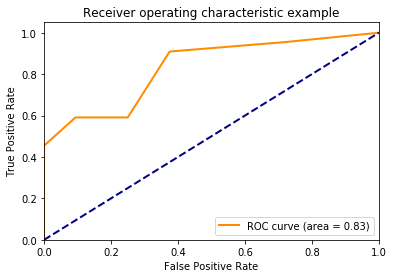

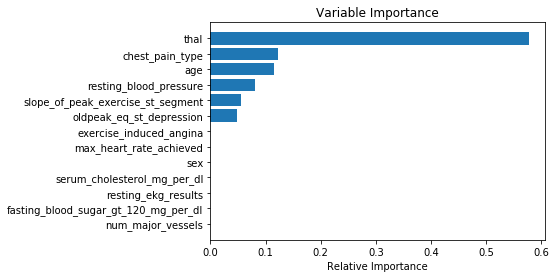

In [4]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth':list(range(5,20,1)), 'min_samples_split':list(range(2,5)), 'min_samples_leaf':list(range(1,10)), 'min_weight_fraction_leaf': [0.0, 0.1], 'random_state':[0]}
dt = DecisionTreeClassifier(criterion='entropy')
dtGSCV = GridSearchCV(dt, parameters, scoring='precision_macro',cv=5)
dtGSCV.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(dtGSCV.best_params_)
print()

tempDict = dtGSCV.best_params_
dtParam= ', '.join('%s = %s' % (k,tempDict[k]) for k in tempDict.keys())

y_true, y_pred = Y_validation, dtGSCV.predict(X_validation)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
dtPrec = mean(temp[0])
dtRec = mean(temp[1])
dtF1 = mean(temp[2])
print('\nDecision Tree Classification Report (validation):\n', classification_report(y_true,y_pred))
dtAcc = metrics.accuracy_score(y_true, y_pred)
print('Decision Tree Accuracy: ',dtAcc)
print()

y_true, y_pred = Y_train, dtGSCV.predict(X_train)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
dtPrecT = mean(temp[0])
dtRecT = mean(temp[1])
dtF1T = mean(temp[2])
print('\nDecision Tree Classification Report For Training:\n', classification_report(y_true,y_pred))
dtAccT = metrics.accuracy_score(y_true, y_pred)
print('Decision Tree Accuracy For Training: ',dtAccT)

#Graphs

bestClassifier = DecisionTreeClassifier()
bestClassifier.set_params(**tempDict)
bestClassifierPerClass = OneVsRestClassifier(bestClassifier)
y_score = np.array(bestClassifierPerClass.fit(X_train, Y_train).predict_proba(X_validation))

fpr = dict()
tpr = dict()
roc_auc = dict()
i=1
fpr[i], tpr[i], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

dtRoc = roc_auc[i]
dtFPR=fpr[i]
dtTPR=tpr[i]

dt.set_params(**tempDict)
dt.fit(X_train, Y_train)
featureNames = trainData.columns.values[1:]
featureImportance = dt.feature_importances_

sorted_importances = np.argsort(featureImportance)
padding = np.arange(len(featureNames)-1) + 0.5
plt.barh(padding, featureImportance[sorted_importances], align='center')

# Customize the plot
plt.yticks(padding, featureNames[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

# Show the plot
plt.show()


Best parameters set found on development set:

{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}


Neural Net Classification Report (validation):
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.76      0.86      0.81        22

    accuracy                           0.83        54
   macro avg       0.83      0.84      0.83        54
weighted avg       0.84      0.83      0.83        54

Neural Net Accuracy:  0.8333333333333334


Neural Net Classification Report Train:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        68
           1       0.85      0.78      0.81        58

    accuracy                           0.83       126
   macro avg       0.84      0.83      0.83       126
weighted avg       0.83      0.83      0.83       126

Neural Net Accuracy Train:  0.8333333333333334


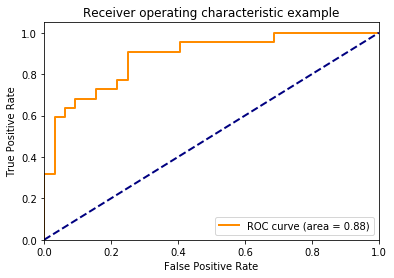

In [5]:
#neural net 
from sklearn.neural_network import MLPClassifier

parameters = { 'hidden_layer_sizes':[x for x in itertools.product(range(5,11,5),repeat=1)], 'activation':('identity', 'logistic', 'tanh', 'relu'), 'alpha':[1e-2,1e-3,1e-4], 
              'learning_rate':('constant', 'invscaling', 'adaptive')}
NN = MLPClassifier()
nnGSCV = GridSearchCV(NN, parameters, scoring='precision_macro',cv=5)
nnGSCV.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(nnGSCV.best_params_)
print()

tempDict = nnGSCV.best_params_
nnParam= ', '.join('%s = %s' % (k,tempDict[k]) for k in tempDict.keys())

y_true, y_pred = Y_validation, nnGSCV.predict(X_validation)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
nnPrec = mean(temp[0])
nnRec = mean(temp[1])
nnF1 = mean(temp[2])
print('\nNeural Net Classification Report (validation):\n', classification_report(y_true,y_pred))
nnAcc = metrics.accuracy_score(y_true, y_pred)
print('Neural Net Accuracy: ',nnAcc)
print()

y_true, y_pred = Y_train, nnGSCV.predict(X_train)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
nnPrecT = mean(temp[0])
nnRecT = mean(temp[1])
nnF1T = mean(temp[2])
print('\nNeural Net Classification Report Train:\n', classification_report(y_true,y_pred))
nnAccT = metrics.accuracy_score(y_true, y_pred)
print('Neural Net Accuracy Train: ',nnAccT)

#Graphs

bestClassifier = MLPClassifier()
bestClassifier.set_params(**tempDict)
bestClassifierPerClass = OneVsRestClassifier(bestClassifier)
y_score = np.array(bestClassifierPerClass.fit(X_train, Y_train).predict_proba(X_validation))

fpr = dict()
tpr = dict()
roc_auc = dict()
i=1
fpr[i], tpr[i], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

nnRoc = roc_auc[i]
nnFPR=fpr[i]
nnTPR=tpr[i]

Best parameters set found on development set:

{'C': 1.5, 'degree': 1, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': 500}


Support Vector Machine Classification Report (validation):
              precision    recall  f1-score   support

          0       0.85      1.00      0.92        34
          1       1.00      0.70      0.82        20

avg / total       0.91      0.89      0.88        54

Support Vector Machine Accuracy:  0.8888888888888888

Support Vector Machine Classification Report Train:
              precision    recall  f1-score   support

          0       0.81      0.92      0.87        66
          1       0.90      0.77      0.83        60

avg / total       0.86      0.85      0.85       126

Support Vector Machine Accuracy Train:  0.9841269841269841


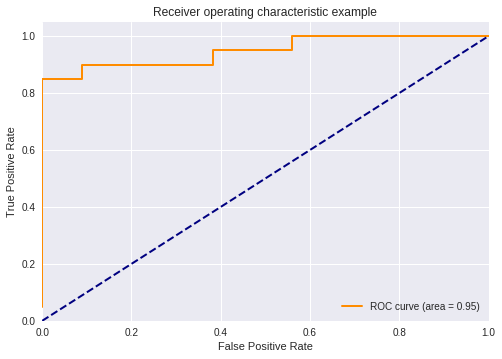

In [0]:
#SVM
from sklearn.svm import SVC

parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(0.5,1.5,11), 'gamma':[1e-3,1e-4],'degree':list(range(1,5)), 'max_iter':[500,1000], 'random_state':list(range(1,5))}
svc = svm.SVC()
svmGSCV = GridSearchCV(svc, parameters, scoring='precision_macro',cv=5)
svmGSCV.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(svmGSCV.best_params_)
print()
tempDict = svmGSCV.best_params_
svmParam= ', '.join('%s = %s' % (k,tempDict[k]) for k in tempDict.keys())

y_true, y_pred = Y_validation, svmGSCV.predict(X_validation)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
svmPrec = mean(temp[0])
svmRec = mean(temp[1])
svmF1 = mean(temp[2])
print('\nSupport Vector Machine Classification Report (validation):\n', classification_report(y_true,y_pred))
svmAcc = metrics.accuracy_score(y_true, y_pred)
print('Support Vector Machine Accuracy: ',svmAcc)

y_true, y_pred = Y_train, svmGSCV.predict(X_train)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
svmPrecT = mean(temp[0])
svmRecT = mean(temp[1])
svmF1T = mean(temp[2])
print('\nSupport Vector Machine Classification Report Train:\n', classification_report(y_true,y_pred))
svmAccT = metrics.accuracy_score(y_true, y_pred)
print('Support Vector Machine Accuracy Train: ',svmAccT)

#Graphs

svc.set_params(**tempDict)
bestClassifier = OneVsRestClassifier(svc)
y_score = np.array(bestClassifier.fit(X_train, Y_train).decision_function(X_validation))

fpr = dict()
tpr = dict()
roc_auc = dict()
i=1
fpr[i], tpr[i], _ = roc_curve(Y_validation, y_score)
roc_auc[i] = auc(fpr[i], tpr[i])
   
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation, y_score)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

svmRoc = roc_auc[i]
svmFPR=fpr[i]
svmTPR=tpr[i]

Best parameters set found on development set:

{'max_features': 0.4, 'max_samples': 0.9, 'n_estimators': 20, 'random_state': 4}


Bagging Classification Report (validation):
              precision    recall  f1-score   support

          0       0.81      0.88      0.85        34
          1       0.76      0.65      0.70        20

avg / total       0.79      0.80      0.79        54

Bagging Accuracy:  0.7962962962962963


Bagging Classification Report Train:
              precision    recall  f1-score   support

          0       0.97      1.00      0.99        66
          1       1.00      0.97      0.98        60

avg / total       0.98      0.98      0.98       126

Bagging Accuracy Train:  0.9841269841269841


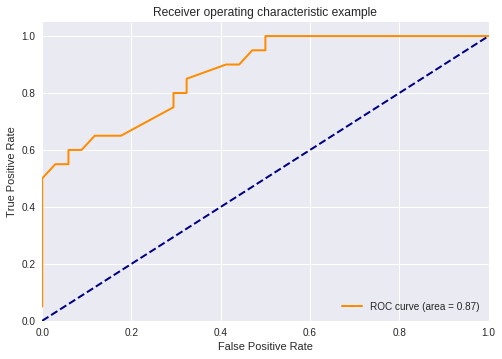

In [0]:
#bagging
from sklearn.ensemble import BaggingClassifier

parameters = {'n_estimators':list(range(20,40,5)), 'max_samples':np.linspace(0.1,1.0,10), 'max_features':np.linspace(0.1,1.0,10)}
    #'tol':[1e-3,1e-4,1e-5],'C':np.linspace(0.1,1.0,50).round(2),'fit_intercept':(True,False),'max_iter':[20,100,1000]}
bag = BaggingClassifier()
bagGSCV = GridSearchCV(bag, parameters, scoring='precision_macro',cv=5)
bagGSCV.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(bagGSCV.best_params_)
print()


sorted(bagGSCV.cv_results_.keys())
tempDict = bagGSCV.best_params_
bagParam= ', '.join('%s = %s' % (k,tempDict[k]) for k in tempDict.keys())

y_true, y_pred = Y_validation, bagGSCV.predict(X_validation)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
bagPrec = mean(temp[0])
bagRec = mean(temp[1])
bagF1 = mean(temp[2])
print('\nBagging Classification Report (validation):\n', classification_report(y_true,y_pred))
bagAcc = metrics.accuracy_score(y_true, y_pred)
print('Bagging Accuracy: ',bagAcc)
print()

y_true, y_pred = Y_train, bagGSCV.predict(X_train)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
bagPrecT = mean(temp[0])
bagRecT = mean(temp[1])
bagF1T = mean(temp[2])
print('\nBagging Classification Report Train:\n', classification_report(y_true,y_pred))
bagAccT = metrics.accuracy_score(y_true, y_pred)
print('Bagging Accuracy Train: ',bagAccT)

#Graphs

bestClassifier = BaggingClassifier()
bestClassifier.set_params(**tempDict)
bestClassifierPerClass = OneVsRestClassifier(bestClassifier)
y_score = np.array(bestClassifierPerClass.fit(X_train, Y_train).predict_proba(X_validation))

fpr = dict()
tpr = dict()
roc_auc = dict()
i=1
fpr[i], tpr[i], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.020000000000000004, 'n_estimators': 12}


Random Forest Classification Report (validation):
              precision    recall  f1-score   support

          0       0.88      0.88      0.88        34
          1       0.80      0.80      0.80        20

avg / total       0.85      0.85      0.85        54

Random Forest Accuracy:  0.8518518518518519


Random Forest Classification Report Train:
              precision    recall  f1-score   support

          0       0.86      0.89      0.87        66
          1       0.88      0.83      0.85        60

avg / total       0.87      0.87      0.86       126

Random Forest Accuracy Train:  0.8650793650793651


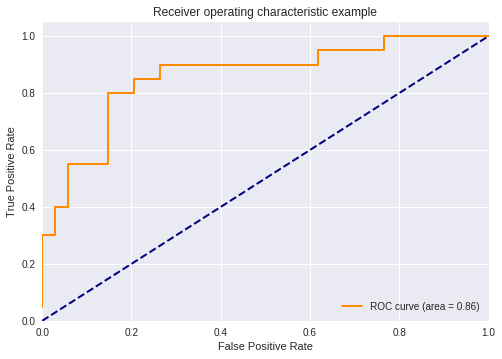

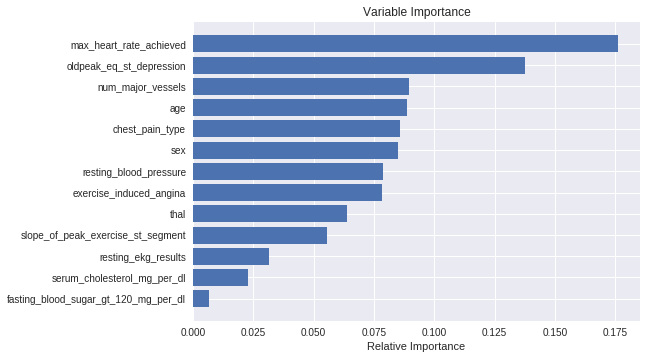

In [0]:
#random forest
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators':list(range(10,20,2)), 'criterion':('gini','entropy'), 'max_depth':list(range(1,10)), 'max_features':np.linspace(0.01,0.1,10)} 
RF = RandomForestClassifier()
RFGSCV = GridSearchCV(RF, parameters, scoring='precision_macro',cv=5)
RFGSCV.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(RFGSCV.best_params_)
print()

sorted(RFGSCV.cv_results_.keys())
tempDict = RFGSCV.best_params_
RFParam= ', '.join('%s = %s' % (k,tempDict[k]) for k in tempDict.keys())

y_true, y_pred = Y_validation, RFGSCV.predict(X_validation)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
RFPrec = mean(temp[0])
RFRec = mean(temp[1])
RFF1 = mean(temp[2])
print('\nRandom Forest Classification Report (validation):\n', classification_report(y_true,y_pred))
RFAcc = metrics.accuracy_score(y_true, y_pred)
print('Random Forest Accuracy: ',RFAcc)
print()

y_true, y_pred = Y_train, RFGSCV.predict(X_train)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
RFPrecT = mean(temp[0])
RFRecT = mean(temp[1])
RFF1T = mean(temp[2])
print('\nRandom Forest Classification Report Train:\n', classification_report(y_true,y_pred))
RFAccT = metrics.accuracy_score(y_true, y_pred)
print('Random Forest Accuracy Train: ',RFAccT)

#Graphs

bestClassifier = RandomForestClassifier()
bestClassifier.set_params(**tempDict)
bestClassifierPerClass = OneVsRestClassifier(bestClassifier)
y_score = np.array(bestClassifierPerClass.fit(X_train, Y_train).predict_proba(X_validation))

fpr = dict()
tpr = dict()
roc_auc = dict()
i=1
fpr[i], tpr[i], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

rfRoc = roc_auc[i]
rfFPR=fpr[i]
rfTPR=tpr[i]

RF.set_params(**tempDict)
RF.fit(X_train, Y_train)
featureNames = trainData.columns.values[1:]
featureImportance = RF.feature_importances_

sorted_importances = np.argsort(featureImportance)
padding = np.arange(len(featureNames)-1) + 0.5
plt.barh(padding, featureImportance[sorted_importances], align='center')

# Customize the plot
plt.yticks(padding, featureNames[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

# Show the plot
plt.show()

Best parameters set found on development set:

{'booster': 'gblinear', 'learning_rate': 0.2, 'max_delta_step': 0.0001, 'n_estimators': 5}


XGBoost Classification Report (validation):
              precision    recall  f1-score   support

          0       0.94      0.85      0.89        34
          1       0.78      0.90      0.84        20

avg / total       0.88      0.87      0.87        54

XGBoost Accuracy:  0.8703703703703703


XGBoost Classification Report Train:
              precision    recall  f1-score   support

          0       0.83      0.88      0.85        66
          1       0.86      0.80      0.83        60

avg / total       0.84      0.84      0.84       126

XGBoost Accuracy Train:  0.8412698412698413


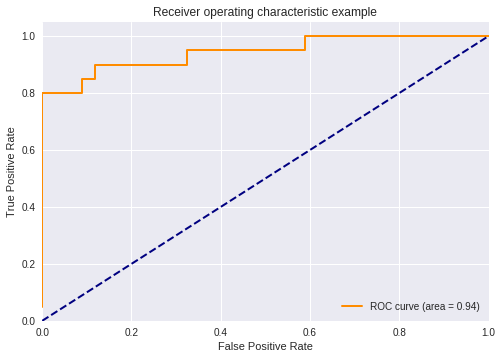

In [0]:
#XGboost
import xgboost as xgboost
from xgboost import XGBClassifier

parameters = {'learning_rate':[5e-1,2e-1,1e-1,1e-2,1e-5], 'n_estimators':list(range(5,41,5)),'booster':('gbtree','gblinear','dart'), 'max_delta_step':np.linspace(0.0001,0.01,100)}
XGb = XGBClassifier()
XGbGSCV = GridSearchCV(XGb, parameters, scoring='precision_macro',cv=5)
XGbGSCV.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(XGbGSCV.best_params_)
print()

sorted(XGbGSCV.cv_results_.keys())
tempDict = XGbGSCV.best_params_
XGbParam= ', '.join('%s = %s' % (k,tempDict[k]) for k in tempDict.keys())

y_true, y_pred = Y_validation, XGbGSCV.predict(X_validation)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
XGbPrec = mean(temp[0])
XGbRec = mean(temp[1])
XGbF1 = mean(temp[2])
print('\nXGBoost Classification Report (validation):\n', classification_report(y_true,y_pred))
XGbAcc = metrics.accuracy_score(y_true, y_pred)
print('XGBoost Accuracy: ',XGbAcc)
print()

y_true, y_pred = Y_train, XGbGSCV.predict(X_train)
temp=metrics.precision_recall_fscore_support(y_true, y_pred)
XGbPrecT = mean(temp[0])
XGbRecT = mean(temp[1])
XGbF1T = mean(temp[2])
print('\nXGBoost Classification Report Train:\n', classification_report(y_true,y_pred))
XGbAccT = metrics.accuracy_score(y_true, y_pred)
print('XGBoost Accuracy Train: ',XGbAccT)

#Graphs

bestClassifier = XGBClassifier()
bestClassifier.set_params(**tempDict)
bestClassifierPerClass = OneVsRestClassifier(bestClassifier)
y_score = np.array(bestClassifierPerClass.fit(X_train, Y_train).predict_proba(X_validation))

fpr = dict()
tpr = dict()
roc_auc = dict()
i=1
fpr[i], tpr[i], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

xgbRoc = roc_auc[i]
xgbFPR=fpr[i]
xgbTPR=tpr[i]

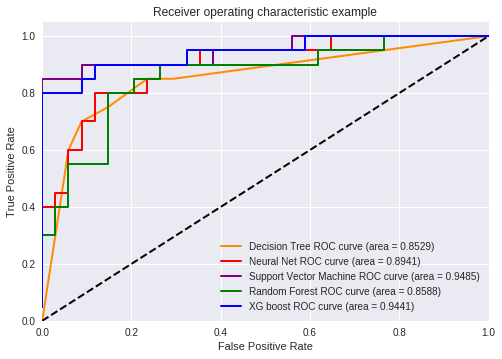

In [0]:
plt.figure()
lw = 2
plt.plot(dtFPR, dtTPR, color='darkorange',
         lw=lw, label='Decision Tree ROC curve (area = %0.4f)' % dtRoc)
plt.plot(nnFPR, nnTPR, color='red',
         lw=lw, label='Neural Net ROC curve (area = %0.4f)' % nnRoc)
plt.plot(svmFPR, svmTPR, color='purple',
         lw=lw, label='Support Vector Machine ROC curve (area = %0.4f)' % svmRoc)
plt.plot(rfFPR, rfTPR, color='green',
         lw=lw, label='Random Forest ROC curve (area = %0.4f)' % rfRoc)
plt.plot(xgbFPR, xgbTPR, color='blue',
         lw=lw, label='XG boost ROC curve (area = %0.4f)' % xgbRoc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
pd.set_option('display.max_colwidth', -1)
tabularResult = np.array([['decision tree',dtParam,dtPrec,dtRec,dtF1,dtAcc,dtAccT],
                          ['neural net',nnParam,nnPrec,nnRec,nnF1,nnAcc,nnAccT],
                          ['support vector machine',svmParam,svmPrec,svmRec,svmF1,svmAcc,svmAccT],
                          #['bagging',bagParam,bagPrec,bagRec,bagF1,bagAcc,bagAccT],
                          ['random forest',RFParam,RFPrec,RFRec,RFF1,RFAcc,RFAccT],
                          ['XGboost',XGbParam,XGbPrec,XGbRec,XGbF1,XGbAcc,XGbAccT]])
test=pd.DataFrame(data=tabularResult,index=['','','','',''],columns=['Algorithm','Best Parameters','Avg Precision','Avg Recall','Avg F1','Accuracy Score','Training Accuracy'])
display(test)

,Algorithm,Best Parameters,Avg Precision,Avg Recall,Avg F1,Accuracy Score,Training Accuracy
,decision tree,"max_depth = 6, min_samples_leaf = 4, min_samples_split = 2, min_weight_fraction_leaf = 0.0, random_state = 0",0.7627840909090908,0.7720588235294117,0.7662337662337663,0.7777777777777778,0.9365079365079365
,neural net,"activation = relu, alpha = 0.001, hidden_layer_sizes = (10, 5, 10, 5), learning_rate = constant",0.8014705882352942,0.8014705882352942,0.8014705882352942,0.8148148148148148,0.873015873015873
,support vector machine,"C = 1.5, degree = 1, gamma = 0.001, kernel = rbf, max_iter = 500",0.925,0.85,0.8712241653418124,0.8888888888888888,0.8492063492063492
,random forest,"criterion = entropy, max_depth = 3, max_features = 0.020000000000000004, n_estimators = 12",0.8411764705882353,0.8411764705882353,0.8411764705882354,0.8518518518518519,0.8650793650793651
,XGboost,"booster = gblinear, learning_rate = 0.2, max_delta_step = 0.0001, n_estimators = 5",0.8590462833099579,0.8764705882352941,0.8647584973166369,0.8703703703703703,0.8412698412698413
